In [1]:
import os
import numpy as np
import pandas as pd

import keras
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.vis_utils import plot_model

from keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers.core import Dropout
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
def data_load(root_path):
    data_pd = pd.read_csv(root_path)
    for feature in data_pd.columns:
        if feature not in ['Date','Vol.', 'Change %']:
            data_pd[feature] = data_pd[feature].str.replace(',','')
            data_pd[feature] = data_pd[feature].astype(float)
            continue
        if feature == 'Vol.':
            data_pd[feature] = data_pd[feature].str.replace('K','')
            data_pd[feature] = data_pd[feature].str.replace('-','-1')
            data_pd[feature] = data_pd[feature].astype(float)
            data_pd[feature] = data_pd[feature]*1000
        if feature == 'Change %':
            data_pd[feature] = data_pd[feature].str.replace('%','')
            data_pd[feature] = data_pd[feature].astype(float)
        if feature == 'Date':
            data_pd[feature] = pd.to_datetime(data_pd[feature])
    
    data_pd['Vol.'] = data_pd['Vol.'].replace(-1, np.nan)
    
    data_pd = data_pd.rename({'Vol.':'vol','Change %':'Change'}, axis=1)
    data_pd = data_pd.loc[:,['Date', 'Price']]
    data_pd = data_pd.sort_values(by=['Date'], ascending=True)
    return data_pd

# 归一化数据,张量转化
def normalizer(data_pd):
    data_series = data_pd['Price'].values
    data_tensor = np.reshape(data_series,(-1,1))

    scaler = MinMaxScaler(feature_range=(0.1, 1))  #自动将dtype转换成float64
    scaled_tensor = scaler.fit_transform(data_tensor)
    
    date_series = data_pd['Date'].values
    return scaled_tensor, scaler,date_series

def data_process(root_path, params):
    train_pd = data_load(root_path + 'HangSengTrain.csv')
    test_pd = data_load(root_path + 'HangSengTest.csv')
    
    train_tensor, train_scaler,traindate_series = normalizer(train_pd)

    test_tensor, test_scaler,testdate_series = normalizer(test_pd)
    
    train_gen = TimeseriesGenerator(train_tensor, train_tensor, 
                    length=params['time_lag'], # 序列长度
                    batch_size=train_tensor.shape[0]-params['time_lag']+1, 
                    shuffle=False)
    test_gen = TimeseriesGenerator(test_tensor, test_tensor, 
                    length=params['time_lag'], # 序列长度
                    batch_size=test_tensor.shape[0]-params['time_lag']+1, 
                    shuffle=False)
    
    train_x,train_y = train_gen[0]
    test_x,test_y = test_gen[0]
    
    train_x = np.reshape(train_x, (train_x.shape[0], 1, -1))
    train_y = np.reshape(train_y, (train_y.shape[0], 1, 1))
    
    test_x = np.reshape(test_x, (test_x.shape[0], 1, -1))
    test_y = np.reshape(test_y, (test_y.shape[0], 1, 1))
    
    data_dic = {'train':{'input_x':train_x,
                         'input_y':train_y,
                         'scaler':train_scaler,
                         'date_series':traindate_series
                        },
                'test':{'input_x':test_x,
                        'input_y':test_y,
                        'scaler':test_scaler,
                        'date_series':testdate_series
                        }
               }
    return data_dic

In [3]:
# lstm建模
def build_lstm(params):
    model = Sequential()
    
    adam = Adam(lr=params[r'lr'], beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.add(LSTM(params['lstm']['nb_hidden_cell'][0],input_shape=(1,params['lstm']['inputDim']),
                   use_bias=True,activation='relu',name='layer_0',return_sequences=True))
    for i in range(1,len(params['lstm']['nb_hidden_cell'])):
        model.add(LSTM(params['lstm']['nb_hidden_cell'][i],activation='tanh',use_bias=True, name='layer_%s'%i,return_sequences=True))
    model.add(Dense(16,use_bias=True,activation='relu',name='pre_last'))
    model.add(Dropout(0.1))
    model.add(Dense(1,use_bias=True,activation='linear',name='last'))
    
    model.compile(optimizer=adam,loss='mse',metrics=['mae','mape'])
    print(model.summary())
    
    plot_model(model, to_file=params[r'modelPicSave'],show_shapes=True)
    return model

In [4]:
# 训练并验证lstm模型
def apply_model(model, data_dic):   
    checkpointer = ModelCheckpoint(filepath=params['ModelCheckpoint_path'],
                                   monitor = 'val_mean_absolute_percentage_error',
                                   save_best_only=True)
    history = model.fit(data_dic['train']['input_x'], 
                        data_dic['train']['input_y'],
                        epochs=params['epochs'], batch_size=params['batch_size'],callbacks = [checkpointer],
                        shuffle=False,validation_split=0.3)
    plot_history(history)
    return model

# 绘制训练过程中的损失曲线
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1,len(loss_values)+1)
    plt.plot(epochs,loss_values,'bo',label='Training loss')
    plt.plot(epochs,val_loss_values,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def evaluation_rmse(y_test, predict_array):
    return np.sqrt(mean_squared_error(y_test, predict_array))

def evaluation_mae(y_test, predict_array):
    return mean_absolute_error(y_test, predict_array)

def evaluation_mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, data_dic):
    # 预测值
    predict_val = model.predict(data_dic['test']['input_x'])
    predict_val = np.reshape(predict_val, (predict_val.shape[0],1))
    predict_val = data_dic['test']['scaler'].inverse_transform(predict_val)
    # 真实值
    true_val = data_dic['test']['input_y']
    true_val = np.reshape(true_val, (true_val.shape[0],1))
    true_val = data_dic['test']['scaler'].inverse_transform(true_val)
    # 误差指标
    rmse = evaluation_rmse(true_val, predict_val)
    mae = evaluation_mae(true_val, predict_val)
    mape = evaluation_mape(true_val, predict_val)
    print('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(rmse,mae,mape))
    return predict_val,true_val

# 绘制真实值与预测值的折现图
def plot_image(predict_vals, true_vals):
    from datetime import datetime
    
    fig= plt.figure(figsize=(16,8))
    dates_series = data_dic['test']['date_series']
    dates_series = pd.to_datetime(dates_series[:dates_series.shape[0] - params['time_lag']],format='%Y-%m-%d')
    
    plt.plot(dates_series,true_vals,'b', label='True Price')
    plt.plot(dates_series,predict_vals,'r', label='Predict Price')
    
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('HangSeng Index Predict')
    
    plt.legend(shadow=True)
    plt.savefig( 'Predict.png', dpi=240)
    plt.show()
    return 

W1021 23:25:08.610495 139799939200768 deprecation_wrapper.py:119] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 23:25:08.648955 139799939200768 deprecation_wrapper.py:119] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 23:25:08.651000 139799939200768 deprecation_wrapper.py:119] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 23:25:09.440549 139799939200768 deprecation_wrapper.py:119] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (LSTM)               (None, 1, 80)             27520     
_________________________________________________________________
layer_1 (LSTM)               (None, 1, 80)             51520     
_________________________________________________________________
layer_2 (LSTM)               (None, 1, 80)             51520     
_________________________________________________________________
pre_last (Dense)             (None, 1, 16)             1296      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
last (Dense)                 (None, 1, 1)              17        
Total params: 131,873
Trainable params: 131,873
Non-trainable params: 0
_________________________________________________________________
None

W1021 23:25:09.950752 139799939200768 deprecation.py:323] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1021 23:25:12.045866 139799939200768 deprecation_wrapper.py:119] From /data/WorkSpace/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 598 samples, validate on 257 samples
Epoch 1/50
598/598 [==============================] - 8s 13ms/step - loss: 0.2875 - mean_absolute_error: 0.4893 - mean_absolute_percentage_error: 95.8355 - val_loss: 0.3688 - val_mean_absolute_error: 0.6020 - val_mean_absolute_percentage_error: 90.8786
Epoch 2/50
598/598 [==============================] - 1s 973us/step - loss: 0.2269 - mean_absolute_error: 0.4270 - mean_absolute_percentage_error: 80.9364 - val_loss: 0.2786 - val_mean_absolute_error: 0.5221 - val_mean_absolute_percentage_error: 78.6627
Epoch 3/50
598/598 [==============================] - 1s 972us/step - loss: 0.1461 - mean_absolute_error: 0.3326 - mean_absolute_percentage_error: 59.9343 - val_loss: 0.1543 - val_mean_absolute_error: 0.3865 - val_mean_absolute_percentage_error: 57.9882
Epoch 4/50
598/598 [==============================] - 1s 995us/step - loss: 0.0590 - mean_absolute_error: 0.1991 - mean_absolute_percentage_error: 34.7535 - val_loss: 0.0428 - val_mean_absolute

598/598 [==============================] - 1s 964us/step - loss: 0.0079 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 15.0215 - val_loss: 0.0013 - val_mean_absolute_error: 0.0301 - val_mean_absolute_percentage_error: 4.5561
Epoch 34/50
598/598 [==============================] - 1s 956us/step - loss: 0.0074 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 14.9199 - val_loss: 0.0013 - val_mean_absolute_error: 0.0296 - val_mean_absolute_percentage_error: 4.4791
Epoch 35/50
598/598 [==============================] - 1s 968us/step - loss: 0.0072 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 14.2512 - val_loss: 0.0020 - val_mean_absolute_error: 0.0376 - val_mean_absolute_percentage_error: 5.6493
Epoch 36/50
598/598 [==============================] - 1s 1ms/step - loss: 0.0076 - mean_absolute_error: 0.0650 - mean_absolute_percentage_error: 15.0407 - val_loss: 0.0011 - val_mean_absolute_error: 0.0277 - val_mean_absolute_percentage_error: 4.198

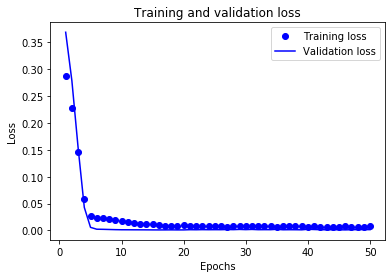

RMSE:450.4197567799056  ,MAE:363.8706608408505  ,MAPE:1.3192825873680463 


/data/WorkSpace/Anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


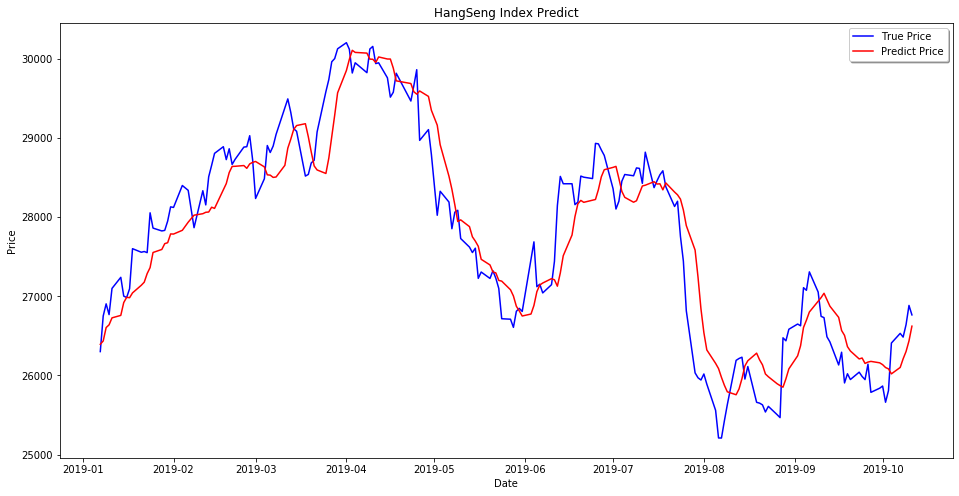

In [5]:
params = {'time_lag':5,
          'batch_size': 10,
          'epochs': 100,
          'lr':1e-4,  # 学习率
          'validation_split':0.3, # 训练中交叉验证比例
          
          'lstm':{'nb_hidden_cell':[80,80,80],
                  'inputDim':5
                 },
          'modelPicSave':r'LSTM_skeleton.png',
          'ModelCheckpoint_path':'checkpoint.hdf5',
         }

# 数据处理，转变格式
root_path = r'/data/WorkSpace/Wells/OfficialWork/P_earn/LSTM_hangseng/SourceData/'
data_dic = data_process(root_path, params)
# 建立模型
model = build_lstm(params)
# 训练模型
model = apply_model(model, data_dic)
# 测试数据验证
predict_val,true_val = evaluate_model(model, data_dic)
# 可视化绘图
plot_image(predict_val, true_val) 